# QPU Solution for Relaxed Embedded Graph - Demo

We solve the MIS problem for a simple (relaxed) embedded graph with a Rydberg simulator. 

## Imports

In [1]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pprint import pprint

from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.aws import AwsDevice
from ahs_utils import show_register, get_drive, show_global_drive
from ahs_utils_demo import generate_graph, run_local, get_result_dic, get_counts

In [2]:
# set seed
np.random.seed(92)

## Problem Setup - Atom Arrangement

In [3]:
# set lattice spacing in SI units (e.g., 5um) 
scale = 4.5*1e-6

In [4]:
# set desired atom positions in square lattice
atom_positions = [(1, 0), (3, 0), (4, 0), 
                  (0, 1), (2, 1), 
                  (1, 2), (3, 2), 
                  (1, 3), (2, 3)]

lattice_width = max([x for x,y in atom_positions]) + 1
lattice_height = max([y for x,y in atom_positions]) + 1

# get node labels
node_labels = range(len(atom_positions))

In [5]:
# node label mapping
label_mapping = {}
label_mapping[0] = '4'
label_mapping[1] = '6'
label_mapping[2] = '1'
label_mapping[3] = '7'
label_mapping[4] = '3'
label_mapping[5] = '5'
label_mapping[6] = '2'
label_mapping[7] = '9'
label_mapping[8] = '8'

In [6]:
# get atom arrangement and graph 
atoms, graph = generate_graph(atom_positions=atom_positions, scale=scale)

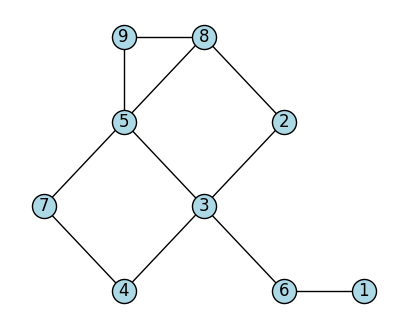

In [7]:
# visualization of problem (target) graph
labelled_graph = dict(zip(graph.nodes(), atom_positions))

fig, ax = plt.subplots(figsize=(5, 4))
nx.draw(graph, pos=labelled_graph, ax=ax, labels=label_mapping, node_color='lightblue', edgecolors='k')
plt.show()

## Problem Setup - Drive/Schedule

In [8]:
# specify linear annealing schedule
omega_min = 0       
omega_max = 3.5e6 * 2 * np.pi
detuning_min = -9e6 * 2 * np.pi
detuning_max = 7e6 * 2 * np.pi

time_max = 4e-6
time_ramp = 0.15*time_max

time_points = [0, time_ramp, time_max - time_ramp, time_max]
omega_values = [omega_min, omega_max, omega_max, omega_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, omega_values, detuning_values, phase_values)
Hfix = Hamiltonian()
Hfix += drive

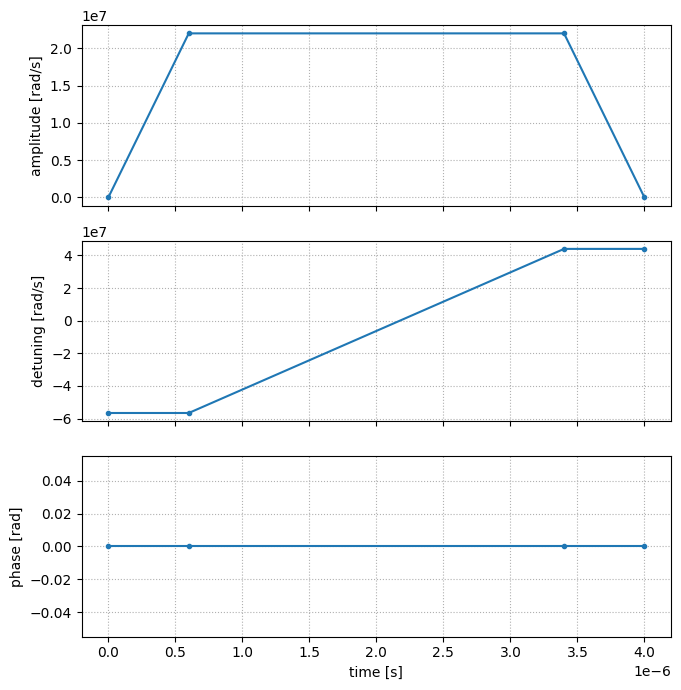

In [9]:
# show drive
show_global_drive(drive)
plt.show()

## Rydberg radius

In [10]:
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

C6 = float(qpu.properties.paradigm.rydberg.c6Coefficient)
r_b_det = (C6/detuning_max)**(1/6) # used in Rydberg review paper (arXiv:1907.09231)
r_b_rabi = (C6/omega_max)**(1/6) # used in Ebadi et al (arXiv:2202.09372)
r_b_det_um = 10**6 * r_b_det
r_b_rabi_um = 10**6 * r_b_rabi
scale_um = 10**6 * scale # a = 4.5 µm in Ebadi et al.

print('Blockade radius (detuning) [um]:', r_b_det_um)
print('Blockade radius (Rabi) [um]:', r_b_rabi_um)
print('Blockade radius Rb/a (detuning) [a]:', r_b_det_um/scale_um)
print('Blockade radius Rb/a (Rabi) [a]:', r_b_rabi_um/scale_um) # Rb/a = 1.7 in Ebadi et al.
print('Distance along diagonal (sqrt(2)a) [um]:', np.sqrt(2)*scale_um)
print('Distance for next-next-nearest neighbors (2a) [um]:', 2*scale_um)

Blockade radius (detuning) [um]: 7.054294119214496
Blockade radius (Rabi) [um]: 7.918177426430267
Blockade radius Rb/a (detuning) [a]: 1.567620915380999
Blockade radius Rb/a (Rabi) [a]: 1.7595949836511704
Distance along diagonal (sqrt(2)a) [um]: 6.3639610306789285
Distance for next-next-nearest neighbors (2a) [um]: 9.0


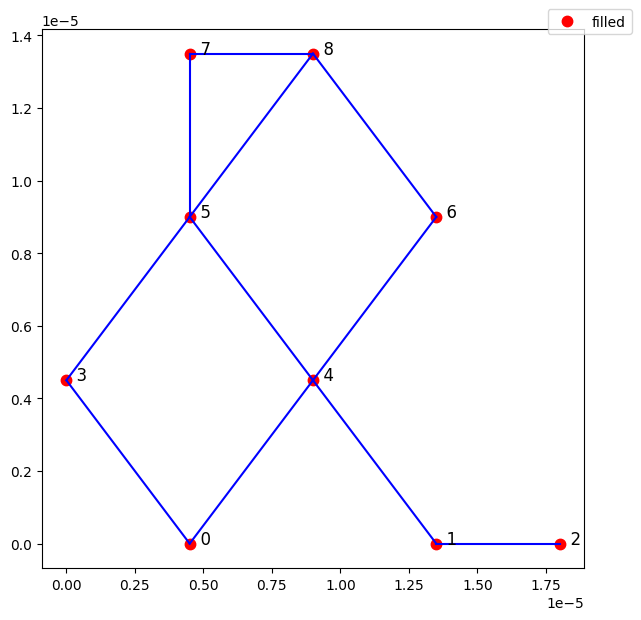

In [11]:
show_register(atoms, blockade_radius=r_b_rabi, what_to_draw="bond")

## Problem Setup - AHS Program

In [12]:
# set up the program 
ahs_program = AnalogHamiltonianSimulation(
    register=atoms, 
    hamiltonian=Hfix
)

## Run Experiment

In [13]:
# run local experiment 
n_shots = 1000
result, runtime = run_local(ahs_program, shots=n_shots)

Time to run AHS with local simulator (in seconds): 37.39873671531677


## Postprocessing

In [14]:
# aggregate results
result_dic = get_result_dic(result)
state_labels, occurence_count = get_counts(result_dic)

In [15]:
# print occurrence counts
pprint(occurence_count)

Counter({'rgrgggrrg': 611,
         'ggrrggrrg': 373,
         'grgrggrrg': 10,
         'ggrrgggrg': 1,
         'ggrrrgggr': 1,
         'ggrrrggrg': 1,
         'rgrgggrgg': 1,
         'rgrggrrgg': 1,
         'rgrrggrrg': 1})


Independent set of 0-th most likely outcome (p=61.10%)
Independent set of 1-th most likely outcome (p=37.30%)
Independent set of 2-th most likely outcome (p=1.00%)


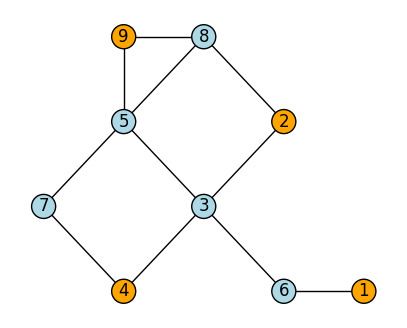

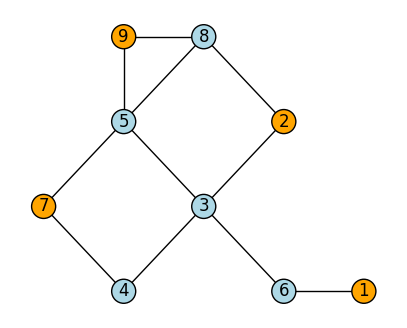

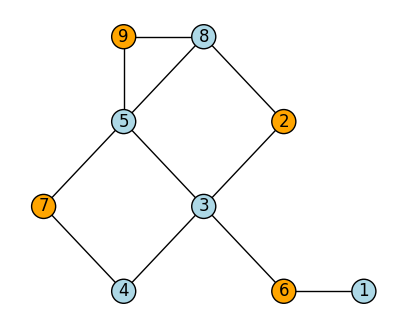

In [16]:
# show most frequent results
most_frequent_regs = occurence_count.most_common(3)
for ii in range(len(most_frequent_regs)):
    fig, ax = plt.subplots(figsize=(5, 4))
    vert_colors = ['orange' if (most_frequent_regs[ii][0][i] == 'r') else 'lightblue' for i in range(len(most_frequent_regs[ii][0]))]
    prob = most_frequent_regs[ii][1]/n_shots
    print(f'Independent set of {ii}-th most likely outcome (p={100*prob:.2f}%)')
    nx.draw(graph, pos=labelled_graph, ax=ax, labels=label_mapping, node_color=vert_colors, edgecolors='k')